# FEAR API

In [3]:
import pandas as pd 
import requests

In [ ]:
url = "https://openapiv1.coinstats.app/insights/fear-and-greed"
headers = {"X-API-KEY": os.getenv('API_KEY')}
response = requests.get(url, headers=headers)
data = response.json()

# Convert to DataFrame
# fag_df = pd.DataFrame(data['data'], columns=['timestamp', 'value'])

# Convert timestamp to datetime (hourly)
# fag_df['TIME_UNIXs'] = pd.to_datetime(fag_df['timestamp'], unit='s').dt.strftime('%Y-%m-%d %H')

# fag_df = fag_df[['TIME_UNIXs', 'timestamp', 'value']]
# fag_df.head()


In [7]:
data['now']['value']
data['now']['timestamp']

{'value': 58,
 'value_classification': 'Neutral',
 'timestamp': 1759669924,
 'update_time': '2025-10-05T13:08:10.048Z'}

In [15]:
data['now']['update_time'].split(":")[0].replace("T"," ")

'2025-10-05 13'

In [ ]:
url = "https://openapiv1.coinstats.app/insights/fear-and-greed"
headers = {"X-API-KEY": os.getenv('API_KEY')}
response = requests.get(url, headers=headers)
print(response.json()['now'])

{'value': 58, 'value_classification': 'Neutral', 'timestamp': 1759669992, 'update_time': '2025-10-05T13:08:10.048Z'}


In [135]:
print(response.json()['now']['value'])

{'value': 39, 'value_classification': 'Fear', 'timestamp': 1759170098, 'update_time': '2025-09-29T18:08:10.028Z'}


In [3]:
import requests
import pandas as pd 
import numpy as np 

In [ ]:
# Should run every hour
def get_fag():
    url = "https://openapiv1.coinstats.app/insights/fear-and-greed"
    headers = {"X-API-KEY": os.getenv('API_KEY')}
    response = requests.get(url, headers=headers)
    respo = response.json()

    # Convert to DataFrame
    fag_df = pd.DataFrame([respo['now']], columns=['value','value_classification', 'timestamp','update_time'])
    # fag_df['']
    # Convert timestamp to datetime (hourly)
    fag_df['TIME_UNIXs'] = pd.to_datetime(fag_df['timestamp'], unit='s').dt.strftime('%Y-%m-%d %H')

    fag_df = fag_df[['TIME_UNIXs', 'timestamp', 'value']]
    return fag_df

In [5]:
fag_df = get_fag()

In [11]:
fag_df

,TIME_UNIXs,timestamp,value
0,2025-10-05 13,1759670062,58


# Dominance API

## CoinStatus

In [69]:
from dotenv import load_dotenv

In [70]:
def config():
    load_dotenv()

In [3]:
import os 

In [8]:
os.getenv

<function os.getenv(key, default=None)>

In [4]:
print(os.getenv('API_KEY'))

None


In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import sys
import joblib
import os 
from dotenv import load_dotenv
env = load_dotenv(dotenv_path=r"C:\Users\Com\OneDrive\Documents\GitHub\Crypto_bot\.env")
from sklearn.preprocessing import StandardScaler
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../Pipeline")))
import GetData
import importlib
import requests


# Should Run once a  day
# First Get Fear and Greed Index using Coin Stat api
def get_dom_fag():
    # get dom 
    dom_url = "https://openapiv1.coinstats.app/insights/btc-dominance"
    querystring = {"type":"24h"}
    headers = {"X-API-KEY":os.getenv('COINSTAT_API_KEY')}
    response = requests.get(dom_url, headers=headers,params=querystring)
    dom_respo = response.json()
    res_pd = pd.DataFrame(dom_respo['data'], columns=['timestamp', 'DOM'])
    res_pd['DATE_STR'] = pd.to_datetime(res_pd["timestamp"], unit='s').dt.strftime('%Y-%m-%d %H:%M:%S').str.split(' ').str[0]
    res_pd['HOUR_STR'] = pd.to_datetime(res_pd['timestamp'], unit='s').dt.strftime('%Y-%m-%d %H:%M:%S').str.split(' ').str[1].str.split(':').str[0].astype(int)
    res_pd = res_pd.groupby(['DATE_STR','HOUR_STR'], as_index=False).mean(numeric_only=True)

    fag_url = "https://openapiv1.coinstats.app/insights/fear-and-greed"
    headers = {"X-API-KEY": os.getenv('COINSTAT_API_KEY')}
    response = requests.get(fag_url, headers=headers)
    fag_respo = response.json()
    # fag_respo['now']['update_time'].split(":")[0].replace("T"," ")
    res_pd['fag'] = fag_respo['now']['value']
    return res_pd


# Function to transform LIVE Data into format that is similar to locally stored data
def transform_live(data_frame):
  # MAKE A DATAFRAME of BTC price and other PARAMS
  hr_by_hr = pd.DataFrame()
  # main params 
  hr_by_hr['TIME_UNIX'] = data_frame['timestamp']
  hr_by_hr['DATE_STR'] = pd.to_datetime(hr_by_hr['TIME_UNIX'], unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S').str.split(' ').str[0]
  hr_by_hr['HOUR_STR'] = pd.to_datetime(hr_by_hr['TIME_UNIX'], unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S').str.split(' ').str[1].str.split(':').str[0].astype(int)
  hr_by_hr['OPEN_PRICE'] = data_frame['open']
  hr_by_hr['HIGH_PRICE'] = data_frame['high']
  hr_by_hr['CLOSE_PRICE'] = data_frame['close']
  hr_by_hr['LOW_PRICE'] = data_frame['low']
  hr_by_hr['VOLUME_FROM'] = data_frame['volume']
  hr_by_hr['VOLUME_TO'] =  hr_by_hr['VOLUME_FROM']/((hr_by_hr['HIGH_PRICE'] +hr_by_hr['LOW_PRICE']+hr_by_hr['CLOSE_PRICE'])/3)
  return hr_by_hr

# MAKE A DATAFRAME of BTC price and other PARAMS for the model
def Feat_extract(data_frame):
  hr_by_hr = pd.DataFrame()
  # main params 
  hr_by_hr['HOUR_STR'] = data_frame['HOUR_STR']
  hr_by_hr['OPEN_PRICE'] = data_frame['OPEN_PRICE']
  hr_by_hr['HIGH_PRICE'] = data_frame['HIGH_PRICE']
  hr_by_hr['CLOSE_PRICE'] = data_frame['CLOSE_PRICE']
  hr_by_hr['LOW_PRICE'] = data_frame['LOW_PRICE']
  hr_by_hr['VOLUME_FROM'] = data_frame['VOLUME_FROM']
  hr_by_hr['VOLUME_TO'] =  data_frame['VOLUME_TO']
  # Fear and Greed Index
  hr_by_hr['FAG'] = data_frame['fag']
  hr_by_hr['FAG'] = hr_by_hr['FAG'] /100  
  # Avg params
  hr_by_hr['ma_24h'] = hr_by_hr['CLOSE_PRICE'].rolling(24).mean()
  hr_by_hr['ma_72h'] = hr_by_hr['CLOSE_PRICE'].rolling(72).mean()
  hr_by_hr['ma_168h'] = hr_by_hr['CLOSE_PRICE'].rolling(168).mean()
  hr_by_hr['TIME_UNIX'] = data_frame['TIME_UNIX']
  # Percentage change with moving avg
  hr_by_hr['vol_8h'] = hr_by_hr['CLOSE_PRICE'].pct_change().rolling(8).std()# 8 hrs
  hr_by_hr['vol_24h'] = hr_by_hr['CLOSE_PRICE'].pct_change().rolling(24).std() # 1 day
  hr_by_hr['vol_72h'] = hr_by_hr['CLOSE_PRICE'].pct_change().rolling(72).std() # 3 days
  # Percentage change
  hr_by_hr['r_24h'] = hr_by_hr['CLOSE_PRICE'].pct_change(24) # 1 day
  hr_by_hr['r_72h'] = hr_by_hr['CLOSE_PRICE'].pct_change(72) # 3 day
  hr_by_hr['r_168h'] = hr_by_hr['CLOSE_PRICE'].pct_change(168) # 1 week
  # Date and time related features
  hr_by_hr['TIME_UNIXs'] = pd.to_datetime(hr_by_hr['TIME_UNIX'], unit='ms')
  hr_by_hr['dayofweek'] = hr_by_hr['TIME_UNIXs'].dt.dayofweek  # 0=Monday
  hr_by_hr['is_weekend'] = (hr_by_hr['TIME_UNIXs'].dt.dayofweek >= 5).astype(int)
  hr_by_hr['hour_sin'] = np.sin(2*np.pi*hr_by_hr['HOUR_STR']/24)
  hr_by_hr['hour_cos'] = np.cos(2*np.pi*hr_by_hr['HOUR_STR']/24)
  hr_by_hr['month'] = hr_by_hr['TIME_UNIXs'].dt.month
  # Add DMOMINANCE to ALL 24 hrs
  hr_by_hr['Dominance'] = data_frame['Dominance']
  hr_by_hr['Dominance'] = hr_by_hr['Dominance'] /100 
  hr_by_hr = hr_by_hr.drop(columns=['TIME_UNIXs','TIME_UNIX']) 
  # hr_by_hr.dropna(inplace=True)
  # hr_by_hr.to_csv( 'BTC_USD_1H_FEAT.csv', index=False)
  return hr_by_hr


# Function to create sequences for LSTM input
def create_sequences(X, time_steps=60):
    Xs= []
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
    return np.array(Xs)

# Extract LIVE DATA
importlib.reload(GetData)
data  = GetData.Manage_data()
live_data  =  data.fetch_ohlcv(limit=500)
live_data['timestamp'] = live_data.index

# Transform LIVE DATA to data similar to local data
live = transform_live(live_data)
# Load local csv
local_df = pd.read_csv("current_data.csv")
# Get Dom and fear 
dom_fag  =  get_dom_fag()


live_data['timestamp'] = live_data.index
transformed_live_data = transform_live(live_data)

new_live = transformed_live_data[
    (transformed_live_data['DATE_STR'] > local_df['DATE_STR'].iloc[-1]) |
    ((transformed_live_data['DATE_STR'] == local_df['DATE_STR'].iloc[-1]) & (transformed_live_data['HOUR_STR'] > local_df['HOUR_STR'].iloc[-1]))
]

if not new_live.empty:
   
  final_df = pd.concat([local_df, new_live], ignore_index=True)
  final_df = final_df.drop_duplicates(subset=['DATE_STR','HOUR_STR'],keep='last')
  final_df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
  final_df.iloc[-24:, final_df.columns.get_loc('Dominance')] = dom_fag['DOM'].values[:24]
  final_df.iloc[-24:, final_df.columns.get_loc('fag')] = dom_fag['fag'].values[:24]
  # Interpolate any NaN values in these columns (optional)
  final_df[['Dominance', 'fag']] = final_df[['Dominance', 'fag']].interpolate(method='linear')
  final_df.to_csv('current_data.csv', index =False)
  print('CSV updated!!!')
else:
   print("CSV Uptodate")
   
ready_data = Feat_extract(final_df)
cl = ready_data.dropna()
model = load_model("best_lstm_model_v2.keras", compile=False)

scaler_X = joblib.load('scaler_X.pkl')
Xx =np.array(cl)
X_scaled = scaler_X.fit_transform(Xx)  
X_seq= create_sequences(X_scaled, 168)
val = model.predict(X_seq)
# val = model.predict(X_seq[-1:])

python-dotenv could not parse statement starting at line 3
python-dotenv could not parse statement starting at line 3
python-dotenv could not parse statement starting at line 3


CSV updated!!!
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


In [ ]:
data = pd.read_csv('current_data.csv')

In [38]:
X_scaled[0]

array([-1.65431041, -0.97985635, -0.70583648, -0.94659051, -0.1661608 ,
       -0.46629836, -0.45870758, -0.59587571, -0.91369197, -0.91956983,
       -1.29509554, -1.10418998, -1.23981765,  0.76309743, -0.19184278,
       -0.40298816,  0.13364737, -0.2799356 , -0.35979138, -0.0092457 ,
        1.41509434, -0.74701788,  0.3603879 ])

In [37]:
X_scaled[: ,3:4]

array([[-0.94659051],
       [-0.90349779],
       [-0.87974171],
       ...,
       [-0.84661558],
       [-0.77921381],
       [-0.78739955]])

In [11]:
val.shape

(879, 1)

In [14]:
data = pd.read_csv("current_data.csv")

In [12]:

scaler_y = joblib.load('scaler_y.pkl')
y_pred = scaler_y.inverse_transform(val.reshape(-1, 1)).reshape(-1)

In [13]:
X_seq[-1:].shape

(1, 168, 23)

In [5]:
val.shape

(879, 1)

In [6]:
ready_data['CLOSE_PRICE'][-711:]

504     115725.79
505     115570.88
506     115759.23
507     115735.24
508     115572.06
          ...    
1210    110739.99
1211    110991.72
1212    110845.55
1213    111155.15
1214    111117.55
Name: CLOSE_PRICE, Length: 711, dtype: float64

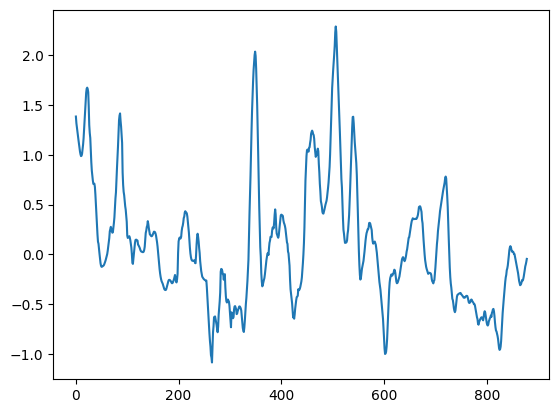

In [7]:
import matplotlib.pyplot as plt
plt.plot(val)

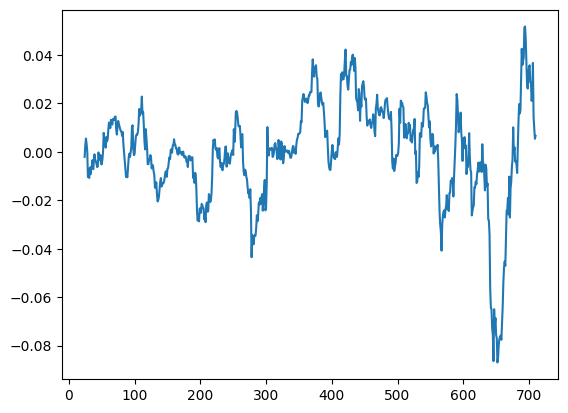

In [71]:
plt.plot(np.asarray(ready_data['CLOSE_PRICE'][-711:].pct_change(24)))

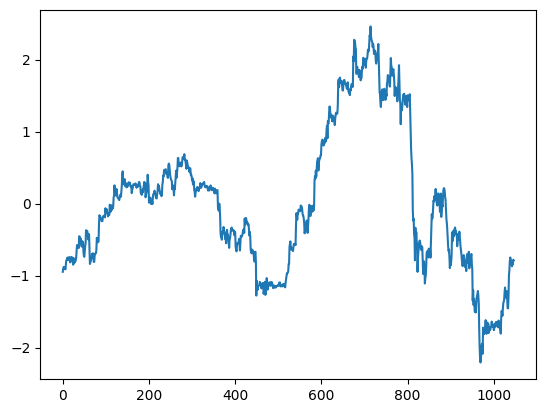

In [39]:
plt.plot(X_scaled[: ,3:4])

In [42]:
np.asarray(X_scaled[: ,3:4]).pct_change().rolling(24).std()

AttributeError: 'numpy.ndarray' object has no attribute 'pct_change'

In [ ]:
new_live

In [ ]:
cl = ready_data.dropna()

In [3]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
Xx =np.array(cl)
X_scaled = scaler_X.fit_transform(Xx)      # keep 2D shape

In [4]:
def create_sequences(X, time_steps=60):
    Xs= []
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
    return np.array(Xs)

X_seq= create_sequences(X_scaled, 168)
print("X_seq.shape:", X_seq.shape)

X_seq.shape: (666, 168, 23)


In [5]:
X_seq.shape

(666, 168, 23)

In [6]:
val = model.predict(X_seq)

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step


In [30]:
val.shape

(666, 1)

In [27]:
val[-1]

array([0.7818806], dtype=float32)

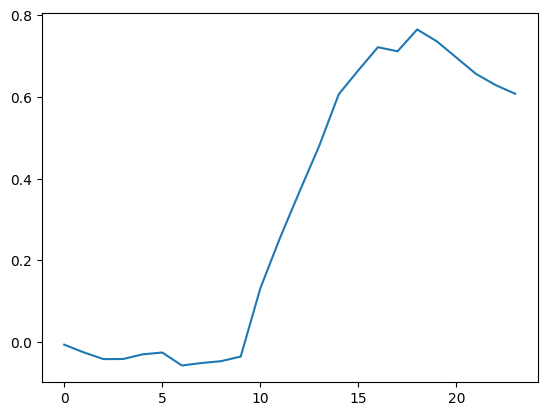

In [7]:
import matplotlib.pyplot as plt
plt.plot(val[-24:])

In [103]:
model = load_model("best_lstm_model_v2.keras", compile=False)

In [105]:
last_168 = ready_data.tail(168)

In [109]:
last_168

,HOUR_STR,OPEN_PRICE,HIGH_PRICE,CLOSE_PRICE,LOW_PRICE,VOLUME_FROM,VOLUME_TO,FAG,ma_24h,ma_72h,...,vol_72h,r_24h,r_72h,r_168h,dayofweek,is_weekend,hour_sin,hour_cos,month,Dominance
834,18,122162.57,122819.44,122625.02,121558.25,2581.33000,0.021101,0.57,120698.652500,118339.154167,...,0.003463,0.016711,0.078109,0.119751,2,0,-1.000000e+00,-1.836970e-16,1,0.588800
835,19,122625.02,123068.76,122774.81,122449.36,2987.68000,0.024337,0.57,120775.420000,118455.568056,...,0.003418,0.015235,0.073272,0.121128,2,0,-9.659258e-01,2.588190e-01,1,0.588800
836,20,122774.81,122824.40,122551.41,122139.05,1238.79000,0.010112,0.57,120851.074583,118565.176389,...,0.003430,0.015039,0.068828,0.119295,2,0,-8.660254e-01,5.000000e-01,1,0.588800
837,21,122551.41,122553.42,122415.48,122113.62,576.48000,0.004711,0.57,120941.772083,118679.236528,...,0.003388,0.018103,0.071910,0.117295,2,0,-7.071068e-01,7.071068e-01,1,0.588800
838,22,122415.48,122756.31,122566.41,122412.97,349.50000,0.002851,0.57,121034.305417,118798.615278,...,0.003369,0.018454,0.075416,0.117333,2,0,-5.000000e-01,8.660254e-01,1,0.588800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,10,124117.48,124832.53,124282.19,124020.00,14.37559,0.000116,0.62,124687.399167,123647.778889,...,0.003576,0.002383,0.017626,0.031513,1,0,5.000000e-01,-8.660254e-01,10,0.556150
998,11,124282.18,124966.86,124446.08,124179.99,10.02099,0.000080,0.62,124696.737917,123682.123611,...,0.003573,0.001804,0.020273,0.028215,1,0,2.588190e-01,-9.659258e-01,10,0.555925
999,12,124453.38,125095.77,124918.00,124350.23,23.00760,0.000184,0.62,124711.794583,123722.573333,...,0.003597,0.002901,0.023871,0.020724,1,0,1.224647e-16,-1.000000e+00,10,0.555700
1000,13,124918.00,125046.16,123909.00,123399.99,52.74281,0.000425,0.62,124665.030833,123743.734306,...,0.003715,-0.008976,0.012449,0.010253,1,0,-2.588190e-01,-9.659258e-01,10,0.555300


In [106]:
X = np.expand_dims(last_168, axis=0)

In [107]:
val = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


In [108]:
val

array([[-0.4023755]], dtype=float32)

In [104]:
live = transform_live(live_data)
local = pd.read_csv("local_2025.csv")

In [ ]:
dom_fag  =  get_dom_fag()
dom_fag

In [ ]:
data  = GetData.Manage_data()
live_data  =  data.fetch_ohlcv(limit=100)
live_data['timestamp'] = live_data.index

In [38]:
transformed_live_data = transform_live(live_data)
transformed_live_data

,TIME_UNIX,DATE_STR,HOUR_STR,OPEN_PRICE,HIGH_PRICE,CLOSE_PRICE,LOW_PRICE,VOLUME_FROM,VOLUME_TO
timestamp,,,,,,,,,
1759316400000,1759316400000,2025-10-01,11,113875.93,116789.00,116789.00,113500.00,16.11028,0.000139
1759320000000,1759320000000,2025-10-01,12,116788.99,116887.00,116390.07,30000.00,19.72984,0.000225
1759323600000,1759323600000,2025-10-01,13,116402.65,116876.80,116795.29,116399.99,24.78741,0.000212
1759327200000,1759327200000,2025-10-01,14,116770.10,117419.69,117300.00,116564.83,11.58503,0.000099
1759330800000,1759330800000,2025-10-01,15,117299.99,117640.56,117417.73,117057.66,12.23709,0.000104
...,...,...,...,...,...,...,...,...,...
1759827600000,1759827600000,2025-10-07,9,123852.55,126477.67,124117.48,123852.55,13.71473,0.000110
1759831200000,1759831200000,2025-10-07,10,124117.48,124832.53,124282.19,124020.00,14.37559,0.000116
1759834800000,1759834800000,2025-10-07,11,124282.18,124966.86,124446.08,124179.99,10.02099,0.000080


In [ ]:
local_df = pd.read_csv("current_data.csv")
new_live = transformed_live_data[
    (transformed_live_data['DATE_STR'] > local['DATE_STR'].iloc[-1]) |
    ((transformed_live_data['DATE_STR'] == local['DATE_STR'].iloc[-1]) & (transformed_live_data['HOUR_STR'] > local['HOUR_STR'].iloc[-1]))
]

final_df = pd.concat([local_df, new_live], ignore_index=True)
final_df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

In [57]:
# nan_rows = final_df[final_df[['Dominance', 'fag']].isna().any(axis=1)]
# nan_rows['DATE_STR'].unique()


array(['2025-10-06', '2025-10-07'], dtype=object)

In [ ]:
final_df.iloc[-24:, final_df.columns.get_loc('Dominance')] = dom_fag['DOM'].values[:24]
final_df.iloc[-24:, final_df.columns.get_loc('fag')] = dom_fag['fag'].values[:24]
# Interpolate any NaN values in these columns (optional)
final_df[['Dominance', 'fag']] = final_df[['Dominance', 'fag']].interpolate(method='linear')

In [95]:
final_df

,TIME_UNIX,DATE_STR,HOUR_STR,OPEN_PRICE,HIGH_PRICE,CLOSE_PRICE,LOW_PRICE,VOLUME_FROM,VOLUME_TO,Dominance,fag
0,1756598400,2025-08-31,0,108833.53,109421.44,109410.18,108826.57,773.08000,0.007078,57.372661,40.0
1,1756602000,2025-08-31,1,109410.18,109510.25,109457.72,109172.76,610.49000,0.005581,57.372661,40.0
2,1756605600,2025-08-31,2,109457.72,109475.46,109252.17,109211.76,261.26000,0.002390,57.372661,40.0
3,1756609200,2025-08-31,3,109252.17,109404.70,109248.19,109197.02,245.96000,0.002251,57.372661,40.0
4,1756612800,2025-08-31,4,109248.19,109257.29,108837.53,108710.64,281.26000,0.002582,57.372661,40.0
...,...,...,...,...,...,...,...,...,...,...,...
921,1759827600000,2025-10-07,9,123852.55,126477.67,124117.48,123852.55,13.71473,0.000110,55.615000,62.0
922,1759831200000,2025-10-07,10,124117.48,124832.53,124282.19,124020.00,14.37559,0.000116,55.592500,62.0
923,1759834800000,2025-10-07,11,124282.18,124966.86,124446.08,124179.99,10.02099,0.000080,55.570000,62.0
924,1759838400000,2025-10-07,12,124453.38,125095.77,124918.00,124350.23,23.00760,0.000184,55.530000,62.0


# Model TEST API

In [67]:
#   hr_by_hr.columns  =  [ 
#        'HOUR_STR', 'OPEN_PRICE', 'HIGH_PRICE',
#        'CLOSE_PRICE', 'LOW_PRICE', 'VOLUME_FROM', 'VOLUME_TO',
#        'Fear_Greed_Index', 'ma_24h', 'ma_72h', 'ma_168h',
#         'vol_8h', 'vol_24h', 'vol_72h', 'r_24h', 'r_72h',
#        'r_168h', 'dayofweek', 'is_weekend',
#        'hour_sin', 'hour_cos', 'month', 'Dominance']

In [ ]:
import pandas as pd
import numpy as np
import sys
import os 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../Pipeline")))
import GetData
import importlib

importlib.reload(GetData)
data  = GetData.Manage_data()
live_data  =  data.fetch_ohlcv(limit=500)
live_data['timestamp'] = live_data.index


In [13]:
live_data

NameError: name 'live_data' is not defined

In [ ]:
# should Run once to generate the CSV file and once every hour to update the Fear and Greed Index
def transform_live(data_frame):
  # MAKE A DATAFRAME of BTC price and other PARAMS
  hr_by_hr = pd.DataFrame()
  # main params 
  hr_by_hr['TIME_UNIX'] = data_frame['timestamp']
  hr_by_hr['DATE_STR'] = pd.to_datetime(hr_by_hr['TIME_UNIX'], unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S').str.split(' ').str[0]
  hr_by_hr['HOUR_STR'] = pd.to_datetime(hr_by_hr['TIME_UNIX'], unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S').str.split(' ').str[1].str.split(':').str[0].astype(int)
  hr_by_hr['OPEN_PRICE'] = data_frame['open']
  hr_by_hr['HIGH_PRICE'] = data_frame['high']
  hr_by_hr['CLOSE_PRICE'] = data_frame['close']
  hr_by_hr['LOW_PRICE'] = data_frame['low']
  hr_by_hr['VOLUME_FROM'] = data_frame['volume']
  hr_by_hr['VOLUME_TO'] =  hr_by_hr['VOLUME_FROM']/((hr_by_hr['HIGH_PRICE'] +hr_by_hr['LOW_PRICE']+hr_by_hr['CLOSE_PRICE'])/3)
  return hr_by_hr

In [12]:
live_data

NameError: name 'live_data' is not defined

In [ ]:
local_2025 = live[live['DATE_STR'] >= ]

# Generate final csv using domination and fear_and_greed csv 

In [191]:
local = pd.read_csv("btc-hourly-price_2015_2025.csv")
dom = pd.read_csv("BTC_DOM.csv")
fag = pd.read_csv("BTC_FAG.csv")

In [192]:
dom['DATE_STR'] = pd.to_datetime(dom['timestamp'], unit = 's').dt.strftime('%Y-%m-%d %H:%M:%S').str.split(' ').str[0]
fag['DATE_STR'] = pd.to_datetime(fag['timestamp'], unit = 's').dt.strftime('%Y-%m-%d %H:%M:%S').str.split(' ').str[0]
dom  = dom.rename(columns={
    'BITCOIN':"Dominance"
})
fag  = fag.rename(columns={
    'score':"fag"
})
fag = fag.drop(columns=['timestamp','btcPrice','btcVolume','name'])
dom = dom.drop(columns=['timestamp'])

In [193]:
local_2025 = local[local['DATE_STR'] >= "2025-08-31"]

In [194]:
loc = local_2025.copy()

In [195]:
local_2025_merg = pd.merge(loc,dom , on='DATE_STR', how='left')

In [196]:
local_2025_merg = pd.merge(local_2025_merg,fag , on='DATE_STR', how='left')

In [197]:
local_df = pd.read_csv('local_2025.csv')
local_df['DATE_STR'] = pd.to_datetime(local_df['TIME_UNIX'], unit = 's').dt.strftime('%Y-%m-%d %H:%M:%S').str.split(' ').str[0]
local_df = local_df.drop(columns=['Unnamed: 0'])

In [235]:
local_df

,TIME_UNIX,DATE_STR,HOUR_STR,OPEN_PRICE,HIGH_PRICE,CLOSE_PRICE,LOW_PRICE,VOLUME_FROM,VOLUME_TO,Dominance,fag
0,1756598400,2025-08-31,0,108833.53,109421.44,109410.18,108826.57,773.080,0.007078,57.372661,40
1,1756602000,2025-08-31,1,109410.18,109510.25,109457.72,109172.76,610.490,0.005581,57.372661,40
2,1756605600,2025-08-31,2,109457.72,109475.46,109252.17,109211.76,261.260,0.002390,57.372661,40
3,1756609200,2025-08-31,3,109252.17,109404.70,109248.19,109197.02,245.960,0.002251,57.372661,40
4,1756612800,2025-08-31,4,109248.19,109257.29,108837.53,108710.64,281.260,0.002582,57.372661,40
...,...,...,...,...,...,...,...,...,...,...,...
859,1759604400,2025-10-04,19,121654.72,122037.19,122037.01,121654.48,273.710,0.002245,59.230000,59
860,1759608000,2025-10-04,20,122037.01,122151.43,121959.56,121959.56,272.550,0.002234,59.230000,59
861,1759611600,2025-10-04,21,121959.56,122410.03,122256.94,121942.78,349.830,0.002863,59.230000,59
862,1759615200,2025-10-04,22,122256.94,122422.82,122359.22,122204.55,269.100,0.002200,59.230000,59


ModuleNotFoundError: No module named 'tensorflow'

### Get Live csv

In [ ]:
import pandas as pd
import numpy as np
import sys
import os 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../Pipeline")))
import GetData
import importlib

importlib.reload(GetData)
data  = GetData.Manage_data()
live_data  =  data.fetch_ohlcv(limit=500)
live_data['timestamp'] = live_data.index

In [150]:
live_plus = live[live['DATE_STR'] > local_df['DATE_STR'].iloc[-1]]

### Find which dates are not in local csv

In [ ]:
live_plus

### Append the new values to the local csv

In [203]:
local_df['VOLUME_TO'] = local_df['VOLUME_FROM']/((local_df['HIGH_PRICE'] +local_df['LOW_PRICE']+local_df['CLOSE_PRICE'])/3)

In [204]:
# append local_df and live plus 
final_df = pd.concat([local_df, live_plus], ignore_index=True)

In [205]:
nan_rows = final_df[final_df[['Dominance', 'fag']].isna().any(axis=1)]
nan_rows

,TIME_UNIX,DATE_STR,HOUR_STR,OPEN_PRICE,HIGH_PRICE,CLOSE_PRICE,LOW_PRICE,VOLUME_FROM,VOLUME_TO,Dominance,fag
864,1759622400000,2025-10-05,0,122379.99,122410.00,122162.77,122159.28,7.71841,0.000063,NaN,NaN
865,1759626000000,2025-10-05,1,122157.71,122410.00,122374.99,122051.83,4.90170,0.000040,NaN,NaN
866,1759629600000,2025-10-05,2,122375.00,124271.95,124120.76,122342.00,13.95791,0.000113,NaN,NaN
867,1759633200000,2025-10-05,3,124120.77,124162.03,123814.00,123395.67,7.38349,0.000060,NaN,NaN
868,1759636800000,2025-10-05,4,123814.01,126581.99,125187.99,123641.38,9.36895,0.000075,NaN,NaN
869,1759640400000,2025-10-05,5,125187.98,130884.20,125127.98,124500.00,9.77368,0.000077,NaN,NaN
870,1759644000000,2025-10-05,6,125127.99,125225.54,125013.57,124640.54,8.79803,0.000070,NaN,NaN
871,1759647600000,2025-10-05,7,125013.58,125149.55,124700.00,121737.05,10.93468,0.000088,NaN,NaN
872,1759651200000,2025-10-05,8,124700.01,125002.75,124595.99,123851.81,5.62571,0.000045,NaN,NaN
873,1759654800000,2025-10-05,9,124596.00,124665.37,123014.24,122878.00,12.57203,0.000102,NaN,NaN


### Fill null values 

In [206]:
nan_rows['DATE_STR'].unique()

array(['2025-10-05', '2025-10-06'], dtype=object)

In [209]:
final_df.loc[final_df['DATE_STR'] == nan_rows['DATE_STR'].unique()[0],'Dominance'] = 59.26

In [210]:
final_df.loc[final_df['DATE_STR'] == nan_rows['DATE_STR'].unique()[1],'Dominance'] = 59.26

In [211]:
final_df.loc[final_df['DATE_STR'] == nan_rows['DATE_STR'].unique()[0],'fag'] = 58.00

In [212]:
final_df.loc[final_df['DATE_STR'] == nan_rows['DATE_STR'].unique()[1],'fag'] = 59.00

In [213]:
final_df

,TIME_UNIX,DATE_STR,HOUR_STR,OPEN_PRICE,HIGH_PRICE,CLOSE_PRICE,LOW_PRICE,VOLUME_FROM,VOLUME_TO,Dominance,fag
0,1756598400,2025-08-31,0,108833.53,109421.44,109410.18,108826.57,773.08000,0.007078,57.372661,40.0
1,1756602000,2025-08-31,1,109410.18,109510.25,109457.72,109172.76,610.49000,0.005581,57.372661,40.0
2,1756605600,2025-08-31,2,109457.72,109475.46,109252.17,109211.76,261.26000,0.002390,57.372661,40.0
3,1756609200,2025-08-31,3,109252.17,109404.70,109248.19,109197.02,245.96000,0.002251,57.372661,40.0
4,1756612800,2025-08-31,4,109248.19,109257.29,108837.53,108710.64,281.26000,0.002582,57.372661,40.0
...,...,...,...,...,...,...,...,...,...,...,...
897,1759741200000,2025-10-06,9,123846.56,124071.85,123955.30,123780.56,12.46958,0.000101,59.260000,59.0
898,1759744800000,2025-10-06,10,123955.29,124142.85,123986.76,123910.93,10.84839,0.000087,59.260000,59.0
899,1759748400000,2025-10-06,11,123986.75,124495.70,124221.95,123759.92,15.36637,0.000124,59.260000,59.0
900,1759752000000,2025-10-06,12,124221.95,124680.29,124556.64,124178.00,10.54685,0.000085,59.260000,59.0


In [214]:
nan_rows = final_df[final_df[['Dominance', 'fag']].isna().any(axis=1)]
nan_rows

,TIME_UNIX,DATE_STR,HOUR_STR,OPEN_PRICE,HIGH_PRICE,CLOSE_PRICE,LOW_PRICE,VOLUME_FROM,VOLUME_TO,Dominance,fag


In [215]:
final_df.to_csv("current_data.csv")

# Transform for Model

In [216]:
transform_dfs =pd.read_csv('current_data.csv')

In [236]:
transform_dfs.head()

,Unnamed: 0,TIME_UNIX,DATE_STR,HOUR_STR,OPEN_PRICE,HIGH_PRICE,CLOSE_PRICE,LOW_PRICE,VOLUME_FROM,VOLUME_TO,Dominance,fag
0,0,1756598400,2025-08-31,0,108833.53,109421.44,109410.18,108826.57,773.08,0.007078,57.372661,40.0
1,1,1756602000,2025-08-31,1,109410.18,109510.25,109457.72,109172.76,610.49,0.005581,57.372661,40.0
2,2,1756605600,2025-08-31,2,109457.72,109475.46,109252.17,109211.76,261.26,0.002390,57.372661,40.0
3,3,1756609200,2025-08-31,3,109252.17,109404.70,109248.19,109197.02,245.96,0.002251,57.372661,40.0
4,4,1756612800,2025-08-31,4,109248.19,109257.29,108837.53,108710.64,281.26,0.002582,57.372661,40.0


In [231]:
def Feat_extract(data_frame):
  # MAKE A DATAFRAME of BTC price and other PARAMS
  hr_by_hr = pd.DataFrame()
  # main params 
  hr_by_hr['HOUR_STR'] = data_frame['HOUR_STR']
  hr_by_hr['OPEN_PRICE'] = data_frame['OPEN_PRICE']
  hr_by_hr['HIGH_PRICE'] = data_frame['HIGH_PRICE']
  hr_by_hr['CLOSE_PRICE'] = data_frame['CLOSE_PRICE']
  hr_by_hr['LOW_PRICE'] = data_frame['LOW_PRICE']
  hr_by_hr['VOLUME_FROM'] = data_frame['VOLUME_FROM']
  hr_by_hr['VOLUME_TO'] =  data_frame['VOLUME_TO']
  # Fear and Greed Index
  hr_by_hr['FAG'] = data_frame['fag']
  hr_by_hr['FAG'] = hr_by_hr['FAG'] /100  
  # Avg params
  hr_by_hr['ma_24h'] = hr_by_hr['CLOSE_PRICE'].rolling(24).mean()
  hr_by_hr['ma_72h'] = hr_by_hr['CLOSE_PRICE'].rolling(72).mean()
  hr_by_hr['ma_168h'] = hr_by_hr['CLOSE_PRICE'].rolling(168).mean()
  hr_by_hr['TIME_UNIX'] = data_frame['TIME_UNIX']
  # Percentage change with moving avg
  hr_by_hr['vol_8h'] = hr_by_hr['CLOSE_PRICE'].pct_change().rolling(8).std()# 8 hrs
  hr_by_hr['vol_24h'] = hr_by_hr['CLOSE_PRICE'].pct_change().rolling(24).std() # 1 day
  hr_by_hr['vol_72h'] = hr_by_hr['CLOSE_PRICE'].pct_change().rolling(72).std() # 3 days
  # Percentage change
  hr_by_hr['r_24h'] = hr_by_hr['CLOSE_PRICE'].pct_change(24) # 1 day
  hr_by_hr['r_72h'] = hr_by_hr['CLOSE_PRICE'].pct_change(72) # 3 day
  hr_by_hr['r_168h'] = hr_by_hr['CLOSE_PRICE'].pct_change(168) # 1 week
  # Date and time related features
  hr_by_hr['TIME_UNIXs'] = pd.to_datetime(hr_by_hr['TIME_UNIX'], unit='ms')
  hr_by_hr['dayofweek'] = hr_by_hr['TIME_UNIXs'].dt.dayofweek  # 0=Monday
  hr_by_hr['is_weekend'] = (hr_by_hr['TIME_UNIXs'].dt.dayofweek >= 5).astype(int)
  hr_by_hr['hour_sin'] = np.sin(2*np.pi*hr_by_hr['HOUR_STR']/24)
  hr_by_hr['hour_cos'] = np.cos(2*np.pi*hr_by_hr['HOUR_STR']/24)
  hr_by_hr['month'] = hr_by_hr['TIME_UNIXs'].dt.month
  # Add DMOMINANCE to ALL 24 hrs
  hr_by_hr['Dominance'] = data_frame['Dominance']
  hr_by_hr['Dominance'] = hr_by_hr['Dominance'] /100 
  hr_by_hr = hr_by_hr.drop(columns=['TIME_UNIXs','TIME_UNIX']) 
  # hr_by_hr.dropna(inplace=True)
  # hr_by_hr.to_csv( 'BTC_USD_1H_FEAT.csv', index=False)
  return hr_by_hr

In [239]:
Model_data = Feat_extract(transform_dfs)

In [242]:
Model_data.to_csv('Model_data_csv.csv', index=False)

In [1]:
import asyncio
import pickle
from datetime import datetime

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../Pipeline")))
from GetData import Manage_data
from Manage_orders import ExecutionEngine
from Logger import TradeLogger
from Visualizer import Visualizerr
from config import Configs
from FeatureExtract import Features
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import dash
from dash import dcc, html, Input, Output
import threading


class CryptoTradingBot:
    def __init__(self, df=None):
        self.data_manager = Manage_data()
        self.execution_engine = ExecutionEngine()
        self.logger = TradeLogger()
        self.visualizer = Visualizerr()
        self.last_timestamp = None
        self.running = False
        self.Extractor = Features()
        self.feature_list  =[
        'price_change', 'price_change_5', 'pos_range_prc',
        'rsi', 'rsi_oversold', 'rsi_overbought',
        'price_above_smal_10', 'price_above_smal_20', 'sma_trend',
        'volume_high', 'high_volatility']
        self.position = None
        self.test_df = df  # premade DataFrame
        with open("Weighted_RFN.pkl", "rb") as f:
            self.models = pickle.load(f)

    def run_bot(self):
        """Main bot execution loop"""
        self.running = True
        
        print(f"Starting crypto trading bot for {Configs.SYMBOL}")
        print(f"Strategy: Random Forest ")
        print(f"Initial Balance: ${Configs.INIT_BALANCE}")
        print("-" * 50)
        

        for i in range( 100, len(self.test_df)-1):  # start after enough candles for indicators
            try:
                df = self.test_df.iloc[: i+1].copy()

                clean_df = df.dropna()
                Ext_Features = self.Extractor.fet_Ext(clean_df)
                feat_list = self.Extractor.feature_list
                clean_df = Ext_Features[feat_list]
                
                self.signal = self.models.predict(clean_df)
                
                self.side = {-1: "sell", 0: "hold", 1: "buy"}

                current_price = df["close"].iloc[-1]
                current_time = df.index[-1]
                # print(self.side[self.signal[-1]])

                # # Check exit conditions
                self.execution_engine.check_exit_conditions(current_price, current_time)

                # # Execute new signal
                self.execution_engine.execute_signal(self.side[self.signal[-1]], current_price, current_time)

                # Log completed trades
                if self.execution_engine.trades:
                    for trade in self.execution_engine.trades:
                        if trade not in getattr(self, 'logged_trades', []):
                            self.logger.log_trade(trade)
                            if not hasattr(self, 'logged_trades'):
                                self.logged_trades = []
                            self.logged_trades.append(trade)

                # Display status
                self.display_status(df, self.signal, current_price)

            except Exception as e:
                print(f"Error in backtest loop: {e}")
                break
    def display_status(self, df, signal, price):
        """Display current bot status"""
        current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        rsi = df['rsi'].iloc[-1] if 'rsi' in df.columns else 0
        
        print(f"\n[{current_time}] Price: ${price:.2f} | RSI: {rsi:.1f} | Signal: {signal}")
        
        if self.execution_engine.position:
            pos = self.execution_engine.position
            unrealized_pnl = pos.calculate_pnl(price)
            print(f"Position: {pos.side.upper()} | Size: {pos.size:.4f} | Entry: ${pos.entry_price:.2f} | Unrealized P&L: ${unrealized_pnl:.2f}")
        
        print(f"Balance: ${self.execution_engine.balance:.2f} | Total Trades: {len(self.execution_engine.trades)}")
    def start_dashboard(self):
        """Start web dashboard in separate thread"""
        bot_ref =  self
        def run_dash():
            # Setup callbacks for live updates
            
            @self.visualizer.app.callback(
                [Output('price-chart', 'figure'),
                 Output('equity-chart', 'figure'),
                 Output('metrics-display', 'children')],
                [Input('interval-component', 'n_intervals')]
            )
            def update_dashboard(n_intervals):
                # Get latest data

                print(f"Dashboard updating... iteration {n_intervals}")  # Debug
                
                df = bot_ref.current_df.copy() if hasattr(bot_ref, 'current_df') and bot_ref.current_df is not None else bot_ref.test_df.copy()
                df = bot_ref.Extractor.fet_Ext(df)
                
                price_fig = self.visualizer.create_price_chart(
                    df, 
                    self.execution_engine.trades, 
                    df['close'].iloc[-1] if len(df) > 0 else 0
                )
                
                equity_fig = self.visualizer.create_equity_curve(
                    self.execution_engine.equity_curve
                )
                
                # Create metrics display
                if len(self.execution_engine.trades) > 0:
                    metrics = self.logger.calculate_metrics(self.execution_engine.trades)
                    metrics_div = html.Div([
                        html.H3("Performance Metrics"),
                        html.P(f"Win Rate: {metrics['win_rate']:.1f}%"),
                        html.P(f"Total P&L: ${metrics['total_pnl']:.2f}"),
                        html.P(f"Total Trades: {metrics['total_trades']}"),
                        html.P(f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}"),
                        html.P(f"Max Drawdown: ${metrics['max_drawdown']:.2f}")
                    ])
                else:
                    metrics_div = html.Div([html.H3("Waiting for trades...")])
                
                return price_fig, equity_fig, metrics_div
            
            self.visualizer.app.run(debug=False, host='127.0.0.1', port=8050)
        
        dashboard_thread = threading.Thread(target=run_dash)
        dashboard_thread.daemon = True
        dashboard_thread.start()
        print("Dashboard started at http://127.0.0.1:8050")

# Some Shit

In [93]:
main = pd.read_csv('BTC_USD_1H_FEAT.csv')

In [87]:
fag =  pd.read_csv('BTC_FAG.csv')

In [89]:
fag['TIME_UNIXs'] = pd.to_datetime(  fag['timestamp'], unit='s' ) 

In [95]:
for i in fag['TIME_UNIXs']:
     if  main[main['TIME_UNIXs']  == i]:
        print("t")

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

# Not working

In [ ]:
import http.client
import json
#import api key from config here
conn = http.client.HTTPSConnection("fear-and-greed-index.p.rapidapi.com")

headers = {
    'x-rapidapi-key': "3f9744d167msh30e7ae02893acbcp17b3c2jsn2232770bcfe8",
    'x-rapidapi-host': "fear-and-greed-index.p.rapidapi.com"
}
conn.request("GET", "/v1/fgi", headers=headers)

res = conn.getresponse()
data = res.read()
# ar = data.decode("utf-8")
# parsed = json.load(ar)
# print()
# data = res.read()
# ar = data.decode("utf-8")
# parsed = json.loads(ar)
# print(parsed)
# print(parsed['fgi']['now']['value'])

In [ ]:
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json

url = 'https://sandbox-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
parameters = {
  'start':'1',
  'limit':'5000',
  'convert':'USD'
}
headers = {
  'Accepts': 'application/json',
  'X-CMC_PRO_API_KEY': 'b54bcf4d-1bca-4e8e-9a24-22ff2c3d462c',
}

session = Session()
session.headers.update(headers)

try:
  response = session.get(url, params=parameters)
  data = json.loads(response.text)
  print(data)
except (ConnectionError, Timeout, TooManyRedirects) as e:
  print(e)